In [1]:
import glob
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import os
from build import build_model
import coralme

In [2]:
from IPython.display import display, HTML, Math, Markdown
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

In [3]:
from coralme.builder.helper_functions import flux_based_reactions
pandas.set_option('display.max_colwidth', None)
plt.rcParams['svg.fonttype'] = 'none'

### Load

In [4]:
overflow = {}
for f in os.listdir("./datasets/"):
    if "2.3.2." not in f:
        continue
    if "overflow" not in f or "all" in f:
        continue
    c = f.replace("_overflow.csv","").replace("2.3.2.","")
    overflow[c] = pandas.read_csv("./datasets/"+f,index_col=0)

In [5]:
overflow = {k:v for k,v in overflow.items() if k!="mid_zinc"}

In [39]:
abundance = pandas.read_csv("./datasets/microbial-abundances-in-CRC-patients-renormalized-only-mapped-models.txt",index_col=1,sep='\t')

In [40]:
mean = abundance.mean(axis=1).to_frame().rename(columns={0:"val"})
std = abundance.std(axis=1).to_frame().rename(columns={0:"val"})

/tmp/ipykernel_282822/3246992827.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean = abundance.mean(axis=1).to_frame().rename(columns={0:"val"})
/tmp/ipykernel_282822/3246992827.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  std = abundance.std(axis=1).to_frame().rename(columns={0:"val"})


### Overflow

In [41]:
def get_weighted(df):
    # Weighted by abundance of microbes
    weighted = {}
    for c in overflow:
        weighted[c] = overflow[c].T.mul(df["val"],axis=0).T
    return weighted

def filter(df,regex):
    return list(df.T[df.columns.str.contains(regex)].index)

def get_total(weighted):
    total = pandas.DataFrame()
    for c in overflow:
        total[c] = weighted[c].sum(axis=1)
    total = total.fillna(0)
    return total[["base"] + filter(total,"low|mid") + filter(total,"high")]

In [42]:
weighted_ovf = get_weighted(mean)
total_ovf = get_total(weighted_ovf)

In [43]:
weighted_err = get_weighted(std)
total_err = get_total(weighted_err)

In [44]:
total_ovf = total_ovf + 1e-16

/tmp/ipykernel_282822/1460907730.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r').copy()


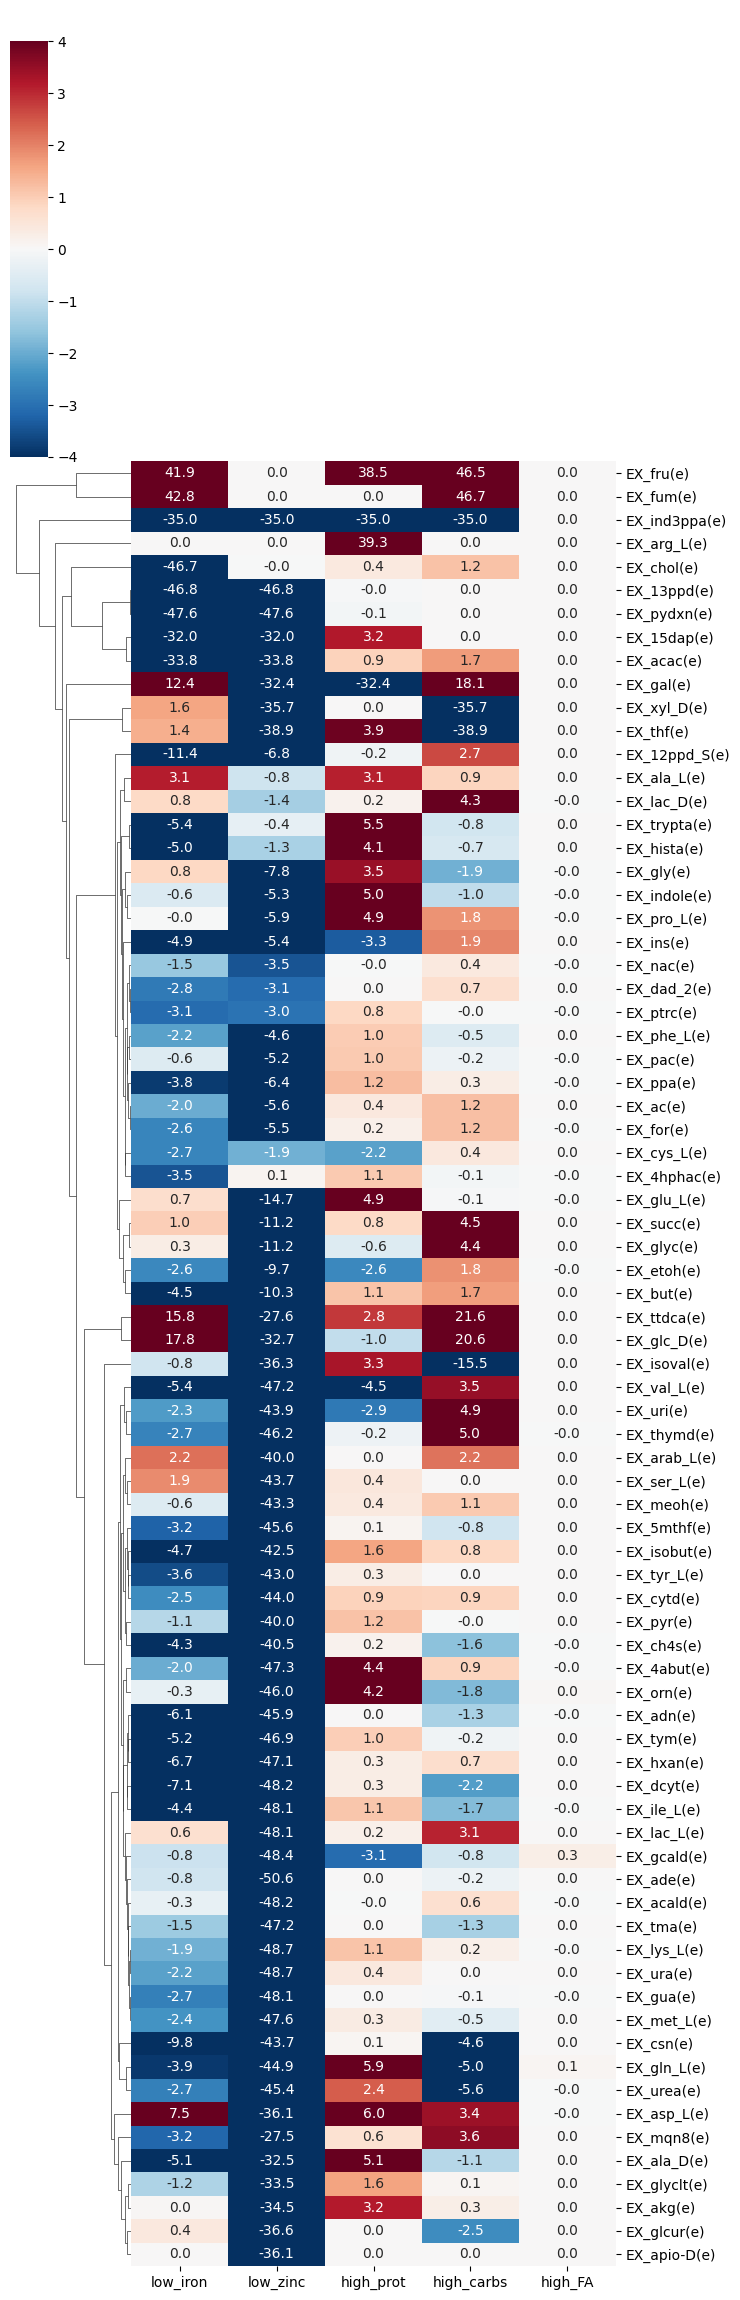

In [78]:
import seaborn as sns
from scipy.stats import zscore
cmap = plt.cm.get_cmap('RdBu_r').copy()

tmp = total_ovf.copy()
# tmp = tmp.apply(zscore,axis=1)
tmp = tmp.div(tmp["base"],axis=0)
# tmp = tmp.subtract(tmp["base"],axis=0)
tmp = tmp.dropna()
tmp = tmp[~tmp.index.str.contains("TS_")]
tmp = tmp.drop("base",axis=1)
tmp = numpy.log2(tmp)
tmp = tmp[(tmp>0).any(axis=1)]
            
# tmp = tmp.T
cmap = sns.clustermap(tmp,
               # row_cluster=False,
               col_cluster=False,
               vmin=-4,
               vmax=4,
               annot=True,
               fmt=".1f",
               cmap=cmap,
               figsize=(1.5*tmp.shape[1],(0.3)*tmp.shape[0]),
               # cbar=False,
              )
# cmap.ax_heatmap.set_xticklabels(cmap.ax_heatmap.get_xticklabels(), rotation=90)
# plt.setp(cmap.ax_heatmap.get_yticklabels(), rotation=0)
# plt.setp(cmap.ax_heatmap.get_xticklabels(), rotation=80)
plt.savefig("./figures/diets_overflow_clustermap.svg",format="SVG")

scFA decrease with iron def

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4659462/

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8047503/

In [79]:
labels = [i.get_text() for i in cmap.ax_heatmap.yaxis.get_majorticklabels()]
tmp.loc[labels].to_csv("./datasets/2.3.2.all_overflow_zscores.csv")

In [118]:
model = coralme.io.pickle.load_pickle_me_model("./me-models/Abiotrophia_defectiva_ATCC_49176/MEModel-BIO-Abiotrophia_defectiva_ATCC_49176-ME-TS.pkl")
import re
mets = {i:re.sub("_(?=[L,D])","__",re.findall("(?<=EX_).*(?=\()",i)[0]) for i in df.columns}
names = {}
for r,m in mets.items():
    if not model.metabolites.query("^"+m):
        print(m)
        names[r] = m
        continue
    names[r] = model.metabolites.get_by_id(m+"_c").name

Read LP format model from file /tmp/tmppf2mqscr.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmpl_hd2xdq.lp
Reading time = 0.00 seconds
: 965 rows, 2096 columns, 9118 nonzeros
Read LP format model from file /tmp/tmppzcp86ok.lp
Reading time = 0.00 seconds
: 995 rows, 2094 columns, 8918 nonzeros
ind3ppa
13ppd
trypta
hista
pac
4hphac
but
isoval
isobut
ch4s
tym
gcald
csn
urea
glcur
apio-D


/tmp/ipykernel_282822/3129773081.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r').copy()


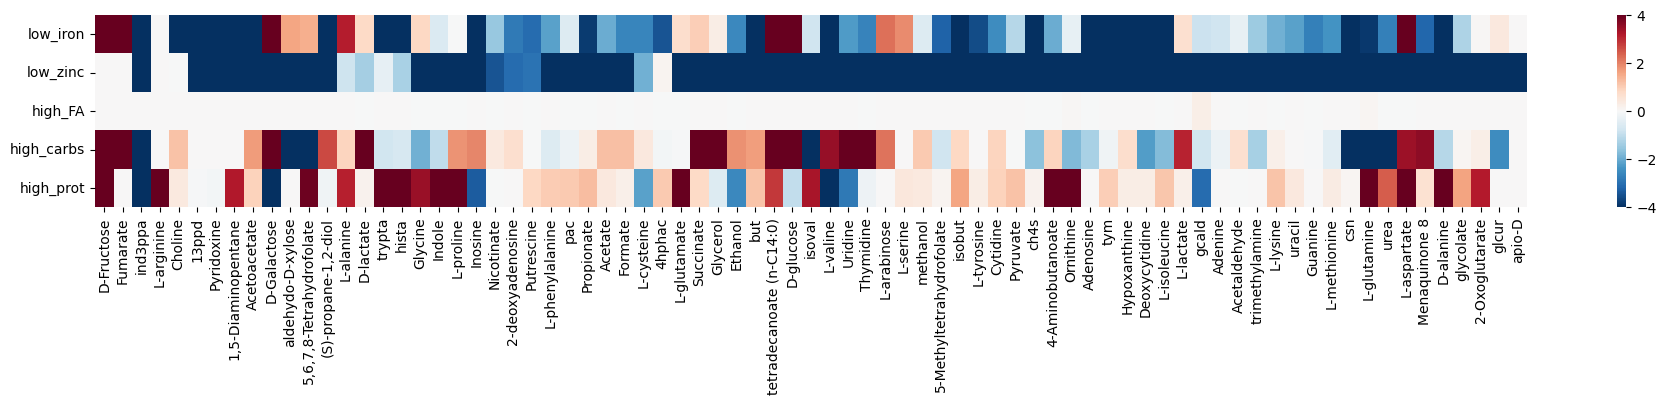

In [124]:
import seaborn as sns
df = tmp.T[labels].loc[["high_prot","high_carbs","high_FA","low_zinc","low_iron"][::-1]]
df = df.T.rename(index=names).T
fig,ax = plt.subplots(1,1, figsize=(0.3*df.shape[1],(0.5)*df.shape[0]))
cmap = plt.cm.get_cmap('RdBu_r').copy()
vmin,vmax = (-4,4)
# cmap.set_under('white')
cmap = sns.heatmap(df,
               vmin=vmin,
               vmax=vmax,
               # annot=True,
               # fmt=".1f",
               cmap=cmap,
               annot_kws={'rotation': 90}
               # figsize=(0.3*df.shape[1],(1.5)*df.shape[0]),
               # cbar=False,
              )
# cmap.ax_heatmap.set_xticklabels(cmap.ax_heatmap.get_xticklabels(), rotation=90)
# _=plt.setp(cmap.ax_heatmap.get_xticklabels(), rotation=80)

plt.savefig("./figures/diets_overflow_clustermap.svg",format="SVG")

In [17]:
weighted_ovf["base"].loc["EX_arab_L(e)"].dropna().sort_values()

Abiotrophia_defectiva_ATCC_49176                      0.000000
Lactobacillus_paracasei_subsp_paracasei_ATCC_25302    0.000000
Lactobacillus_paracasei_subsp_paracasei_8700_2        0.000000
Lactobacillus_oris_F0423                              0.000000
Lactobacillus_mucosae_LM1                             0.000000
                                                        ...   
Bacteroides_fragilis_3_1_12                           0.000016
Bacteroides_fragilis_638R                             0.000016
Bacteroides_fragilis_NCTC_9343                        0.000016
Bacteroides_fragilis_YCH46                            0.000016
Parabacteroides_merdae_ATCC_43184                     0.000038
Name: EX_arab_L(e), Length: 306, dtype: float64

In [18]:
condition = "low_iron"
org = "Bacteroides_ovatus_ATCC_8483"
metabolite = "arab__L_e"

In [19]:
model = coralme.io.pickle.load_pickle_me_model("./me-models/{}/MEModel-BIO-{}-ME-TS.pkl".format(org,org))
fluxes = pandas.read_csv("./cases/fluxes/{}/{}.csv".format(condition,org),index_col=0)
flux_based_reactions(model,metabolite,flux_dict = fluxes["fluxes"].to_dict())

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-16
Read LP format model from file /tmp/tmpe4peu18b.lp
Reading time = 0.00 seconds
: 0 rows, 0 columns, 0 nonzeros
Read LP format model from file /tmp/tmprrqmzedo.lp
Reading time = 0.00 seconds
: 1122 rows, 2634 columns, 10748 nonzeros
Read LP format model from file /tmp/tmpjqomp6h0.lp
Reading time = 0.00 seconds
: 1147 rows, 2632 columns, 10626 nonzeros


,lb,ub,rxn_flux,met_flux,reaction
EX_arab_L(e),-0.178783,1000.0,0.025780,-0.025780,1.0 arab__L_e <=>
ARABINANASEe_FWD_CPLX_dummy,0.0,1000.0,0.000166,0.016129,[4.27350427350427e-6*mu] CPLX_dummy + 1.0 arabinan101_e + 100.0 h2o_e --> 97.0 arab__L_e + 1.0 gal_e + 2.0 galur_e + 1.0 rmn_e
ARABINOXYL_DEGe_FWD_CPLX_dummy,0.0,1000.0,0.000307,0.005520,[4.27350427350427e-6*mu] CPLX_dummy + 1.0 arabinoxyl_e + 53.0 h2o_e --> 18.0 arab__L_e + 3.0 gal_e + 3.0 glc__D_e + 30.0 xyl__D_e
ARABINOGALASEe_FWD_CPLX_dummy,0.0,1000.0,0.000022,0.002016,[4.27350427350427e-6*mu] CPLX_dummy + 1.0 arabinogal_e + 659.0 h2o_e --> 92.0 arab__L_e + 552.0 gal_e + 15.0 glcur_e + 15.0 h_e
RHAMNOGALURASEe_II_FWD_CPLX_dummy,0.0,1000.0,0.000267,0.001602,[4.27350427350427e-6*mu] CPLX_dummy + 52.0 h2o_e + 1.0 rhamnogalurII_e --> 2.0 2omfuc_e + 2.0 2omxyl_e + 2.0 3ddlhept_e + 1.0 acerA_e + 3.0 apio__D_e + 6.0 arab__L_e + 2.0 fuc__L_e + 3.0 gal_e + 19.0 galur_e + 3.0 glcur_e + 2.0 kdo_e + 8.0 rmn_e
RHAMNOGALURASEe_I_FWD_CPLX_dummy,0.0,1000.0,0.000014,0.000435,[4.27350427350427e-6*mu] CPLX_dummy + 979.0 h2o_e + 1.0 rhamnogalurI_e --> 30.0 arab__L_e + 120.0 gal_e + 620.0 galur_e + 200.0 rmn_e + 10.0 xyl__D_e
XYLUGLC_DEGe_FWD_CPLX_dummy,0.0,1000.0,0.000013,0.000079,[4.27350427350427e-6*mu] CPLX_dummy + 1133.0 h2o_e + 1.0 xyluglc_e --> 6.0 arab__L_e + 60.0 fuc__L_e + 108.0 gal_e + 600.0 glc__D_e + 360.0 xyl__D_e
ARABASE3e_FWD_411476.11.peg.2942-MONOMER,0.0,1000.0,0.000000,0.000000,[2.36595359357503e-6*mu] 411476.11.peg.2942-MONOMER + 1.0 arabttr_e + 2.0 h2o_e --> 3.0 arab__L_e
ARBabc_FWD_CPLX_dummy,0.0,1000.0,0.000000,0.000000,[4.27350427350427e-6*mu] CPLX_dummy + 1.0 arab__L_e + 1.0 atp_c + 1.0 h2o_c --> 1.0 adp_c + 1.0 arab__L_c + 1.0 h_c + 1.0 pi_c
ARABASE3e_FWD_411476.11.peg.2352-MONOMER,0.0,1000.0,0.000000,0.000000,[2.67259480025435e-6*mu] 411476.11.peg.2352-MONOMER + 1.0 arabttr_e + 2.0 h2o_e --> 3.0 arab__L_e
